# Nearest node function

Notebook that tests the nearest node function and the new distance functions.

## Import used modules

In [1]:
import os
import sys

import pandas as pd
import geopandas as gpd
import osmnx as ox
import time
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

## Download municipality GeoDataFrame

In [12]:
#gdf = aup.gdf_from_db("mpos_2020", "marco")
mpos = ["02003", "02004", "02005"]
mun_gdf = gpd.GeoDataFrame()
hex_bins = gpd.GeoDataFrame()
for m in mpos:
    query = f"SELECT * FROM marco.mpos_2020 WHERE \"CVEGEO\" LIKE \'{m}\'"
    mun_gdf = mun_gdf.append(aup.gdf_from_query(query, geometry_col='geometry'))
    query = f"SELECT * FROM hexgrid.hex_grid WHERE \"CVEGEO\" LIKE \'{m}%%\'"
    hex_bins = hex_bins.append(aup.gdf_from_query(query, geometry_col='geometry'))
mun_gdf.head(1)

,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry
0,02003,02,003,Tecate,"POLYGON ((-116.68319 32.57160, -116.66266 32.5..."


<AxesSubplot:>

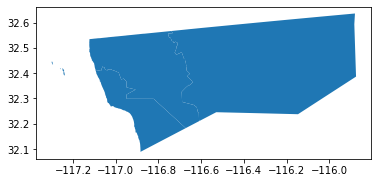

In [13]:
mun_gdf.plot()

In [14]:
print(hex_bins.shape)
hex_bins.head(2)

(5273, 3)


,geometry,hex_id_8,CVEGEO
0,"POLYGON ((-116.30813 32.47593, -116.30929 32.4...",8848593137fffff,02003
1,"POLYGON ((-116.35400 32.41818, -116.35284 32.4...",8848593333fffff,02003


<AxesSubplot:>

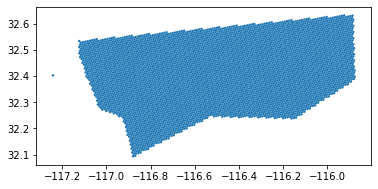

In [15]:
hex_bins.plot()

## Download OSMnx

In [16]:
G, nodes, edges = aup.graph_from_hippo(mun_gdf, 'osmnx')

(96769, 4)


<AxesSubplot:>

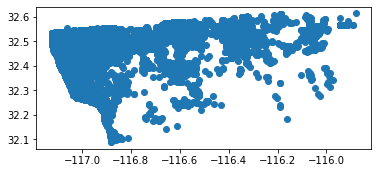

In [17]:
print(nodes.shape)
nodes.plot()

(243015, 3)


<AxesSubplot:>

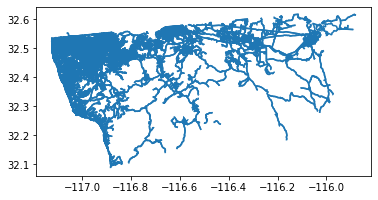

In [18]:
print(edges.shape)
edges.plot()

In [19]:
poly = mun_gdf.geometry
## Extracts coordinates from polygon as DataFrame
coord_val = poly.bounds
## Gets coordinates for bounding box
n = coord_val.maxy.max()
s = coord_val.miny.min()
e = coord_val.maxx.max()
w = coord_val.minx.min()

In [20]:
# Downloads OSMnx graph from bounding box
G = ox.graph_from_bbox(n, s, e, w, network_type="all")

In [21]:
nodes_G, edges_G = ox.graph_to_gdfs(G)

(123151, 6)


<AxesSubplot:>

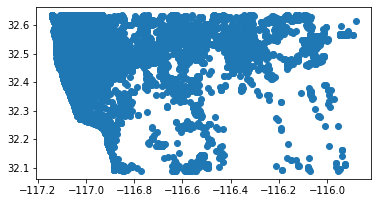

In [22]:
print(nodes_G.shape)
nodes_G.plot()

(311372, 16)


<AxesSubplot:>

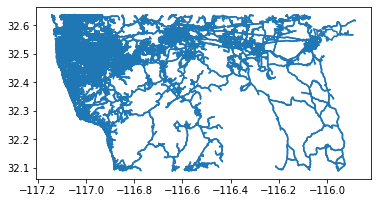

In [23]:
print(edges_G.shape)
edges_G.plot()

In [24]:
query = f"SELECT * FROM osmnx.nodes WHERE (\"x\" between \'{w}\' and \'{e}\') and (\"y\" between \'{s}\' and \'{n}\')"
nodes = aup.gdf_from_query(query, geometry_col='geometry')
print(nodes.shape)
nodes.head(2)

(122934, 5)


,osmid,x,y,street_count,geometry
0,7163030390,-116.616870,32.094626,3,POINT (-116.61687 32.09463)
1,2701664746,-116.601248,32.107956,1,POINT (-116.60125 32.10796)


<AxesSubplot:>

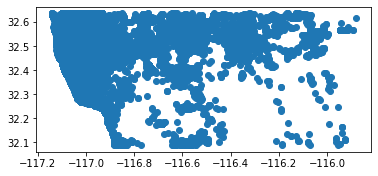

In [25]:
nodes.plot()

(311430, 18)


<AxesSubplot:>

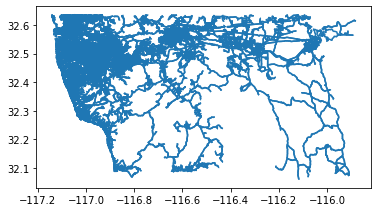

In [27]:
poly_wkt = f"POLYGON(({w} {s}, {w} {n}, {e} {n}, {e} {s}, {w} {s}))"
query = f"SELECT * FROM osmnx.edges WHERE ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')"
edges = aup.gdf_from_query(query, geometry_col='geometry')
print(edges.shape)
edges.plot()

## Amenities

In [10]:
cod_act = {'farmacia':[464111,464112]}

In [11]:
gdf_tmp = mun_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]

for a in cod_act:
            denue_amenity = gpd.GeoDataFrame()
            for cod in cod_act[a]:
                query = f"SELECT * FROM denue_nodes.denue_node_2020 WHERE (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')) AND (\"codigo_act\" = {cod})"
                denue_amenity = denue_amenity.append(aup.gdf_from_query(query, geometry_col='geometry'))

In [12]:
print(denue_amenity.shape)
denue_amenity.head(2)

(386, 5)


,id,codigo_act,geometry,osmid,distance_node
0,23279.0,464111.0,POINT (-102.29652 21.87624),8578029075,27.489211
1,8217258.0,464111.0,POINT (-102.24998 21.91527),1760549310,28.647746


<AxesSubplot:>

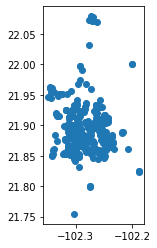

In [13]:
denue_amenity.plot()

## Calculating distance to amenities

In [14]:
nodes_distance = aup.calculate_distance_nearest_poi(denue_amenity, nodes.copy(), edges.copy(), a, 'osmid')
print(nodes_distance.shape)
nodes_distance.head(2)

(50052, 5)


,x,y,street_count,geometry,dist_farmacia
osmid,,,,,
272921360,-102.295073,21.872876,3,POINT (-102.29507 21.87288),334.213
272921393,-102.295097,21.871411,4,POINT (-102.29510 21.87141),183.576


<AxesSubplot:>

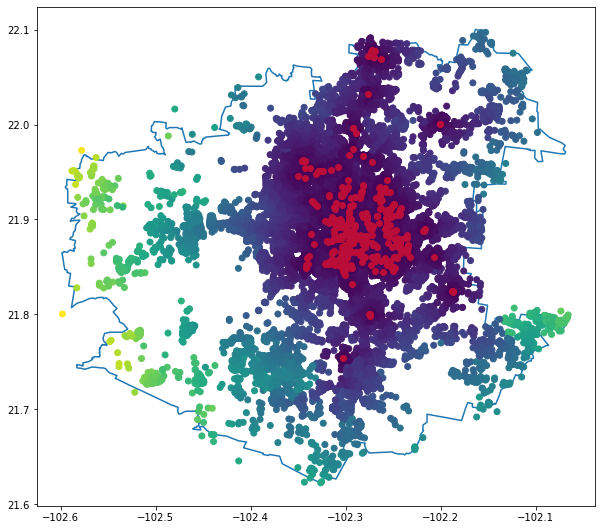

In [15]:
fig,ax = plt.subplots(figsize=(10,10))
denue_amenity.plot(ax=ax, color='#ba0d38',zorder=1)
nodes_distance.plot(nodes_distance['dist_'+a], ax=ax, zorder=-1)
mun_gdf.dissolve().boundary.plot(ax=ax, zorder=-2)

### Distance to hex_bins

In [16]:
nodes_distance.reset_index(inplace=True)
hex_bins = hex_bins.to_crs("EPSG:4326")
hex_dist = aup.group_by_hex_mean(nodes_distance,hex_bins,8,'farmacia')
hex_dist.head(2)

,geometry,hex_id_8,CVEGEO,x,y,street_count,dist_farmacia
0,"POLYGON ((-102.31835 21.82096, -102.31376 21.8...",88498eacd7fffff,01001,-102.320189,21.826943,2.836735,3709.637939
1,"POLYGON ((-102.13473 21.73731, -102.13522 21.7...",88498ea8abfffff,01001,0.000000,0.000000,0.000000,0.000000


<AxesSubplot:>

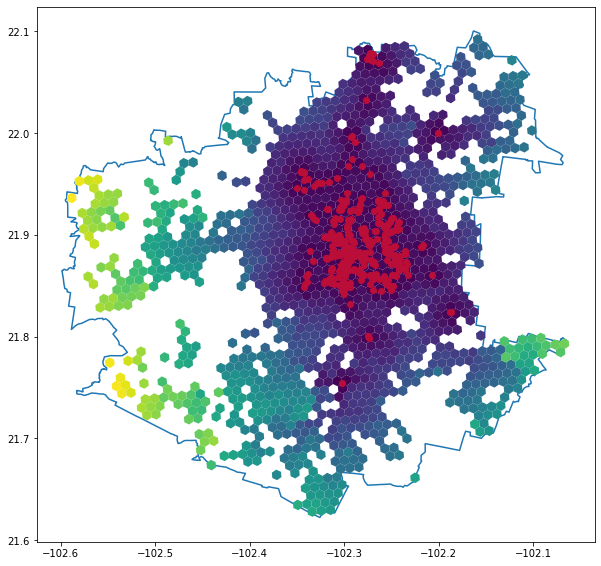

In [17]:
fig,ax = plt.subplots(figsize=(10,10))
denue_amenity.plot(ax=ax, color='#ba0d38',zorder=1)
mun_gdf.dissolve().boundary.plot(ax=ax, zorder=-2)
hex_dist.loc[hex_dist.dist_farmacia>0].plot(hex_dist.loc[hex_dist.dist_farmacia>0]['dist_'+a], ax=ax, zorder=-1)

### Data analysis

In [18]:
print('mean',hex_dist.loc[hex_dist.dist_farmacia>0]['dist_'+a].mean(),
      'std',hex_dist.loc[hex_dist.dist_farmacia>0]['dist_'+a].std())

mean 8317.453473431902 std 7576.699389637319


<AxesSubplot:>

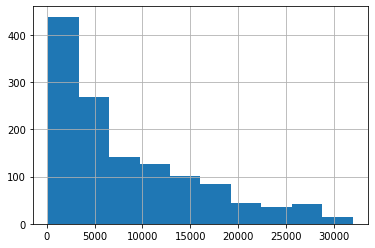

In [19]:
hex_dist.loc[hex_dist.dist_farmacia>0]['dist_'+a].hist()

## Testing for all ammenities

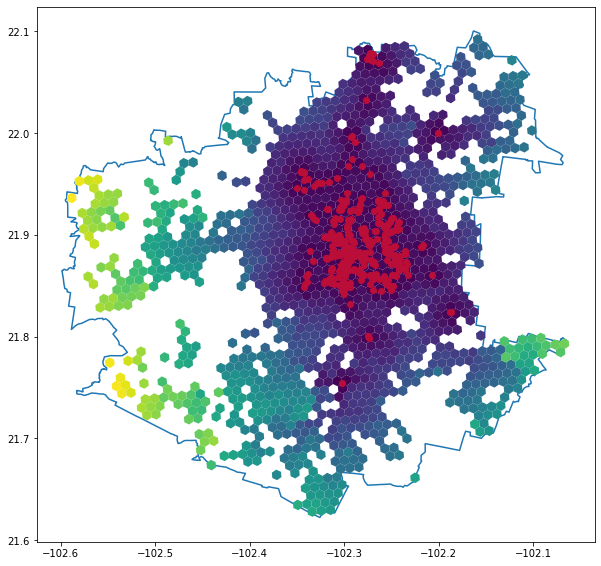

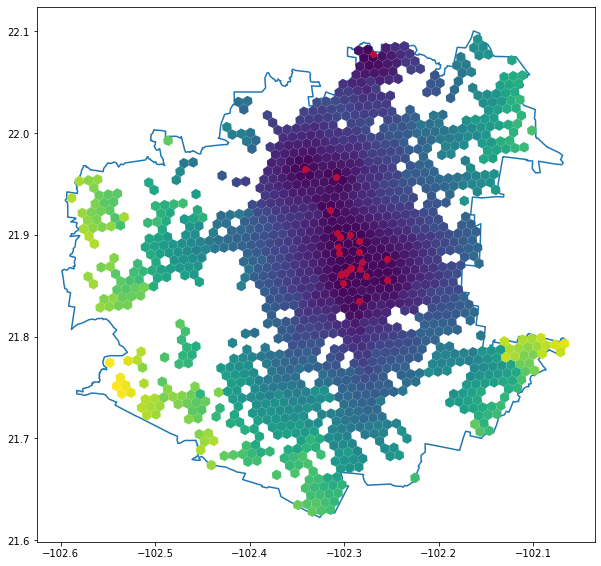

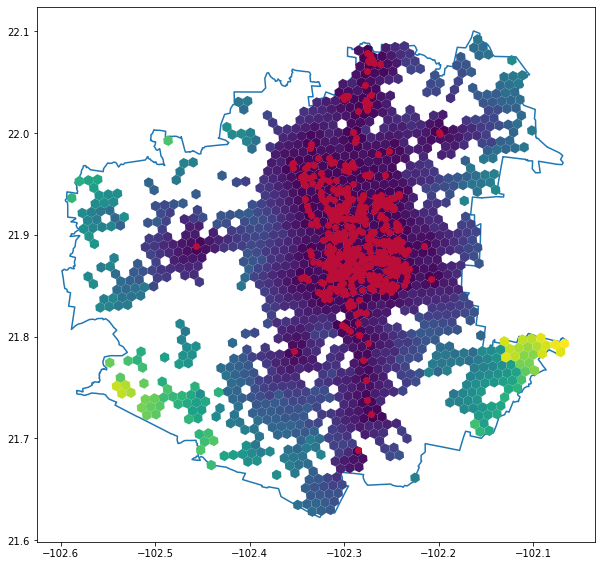

In [24]:
amenities = {'farmacia':[464111,464112],'hospitales':[622111,622112], 
    'supermercados':[462111,462112]}
resolution = 8
#Creates wkt for query
gdf_tmp = mun_gdf.copy()
gdf_tmp = gdf_tmp.to_crs("EPSG:6372")
gdf_tmp = gdf_tmp.buffer(1).reset_index().rename(columns={0:'geometry'})
gdf_tmp = gdf_tmp.to_crs("EPSG:4326")
poly_wkt = gdf_tmp.dissolve().geometry.to_wkt()[0]
aup.log("Created wkt based on dissolved polygon")

nodes_amenities = gpd.GeoDataFrame()
i = 0

for a in amenities:
    denue_amenity = gpd.GeoDataFrame()
    for cod in amenities[a]:
        query = f"SELECT * FROM denue_nodes.denue_node_2020 WHERE (ST_Intersects(geometry, \'SRID=4326;{poly_wkt}\')) AND (\"codigo_act\" = {cod})"
        denue_amenity = denue_amenity.append(aup.gdf_from_query(query, geometry_col='geometry'))

    nodes_distance = aup.calculate_distance_nearest_poi(denue_amenity, nodes.copy(), edges.copy(), a, 'osmid')

    #Data to hex_bins
    nodes_distance.reset_index(inplace=True)
    hex_dist = aup.group_by_hex_mean(nodes_distance, hex_bins, resolution, a)
    hex_bins = hex_bins.merge(hex_dist[['hex_id_'+str(resolution),'dist_'+a]], on='hex_id_'+str(resolution))

    if i == 0:
        nodes_amenities = nodes_distance[['osmid','x','y','dist_'+a,'geometry']]
    else:
        nodes_amenities = nodes_amenities.merge(
            nodes_distance[['osmid','dist_'+a]], on='osmid')
    i += 1
    
    fig,ax = plt.subplots(figsize=(10,10))
    denue_amenity.plot(ax=ax, color='#ba0d38',zorder=1)
    mun_gdf.dissolve().boundary.plot(ax=ax, zorder=-2)
    hex_dist.loc[hex_dist['dist_'+a]>0].plot(hex_dist.loc[hex_dist['dist_'+a]>0]['dist_'+a], ax=ax, zorder=-1)
    plt.show()